# Demonstration of Conformal Predictors

This notebook applies Conformal Prediction to the MNIST dataset to illustrate some aspects of the technique.

The MNIST dataset is downloaded, split into *proper training set*, *calibration set*, and *test set*, and used to train a multi-class SVC.
The SVC is then used to produce scores on the calibration set and on the test set (training and evaluation can require more than 10min, but the results are stored in a `.npz` file which is used on subsequent executions of the notebook).    
The resulting scores are converted into NonConformity Measures (NCM) and the p-value for each of the 10 possible labels are computed using Mondrian (aka label-conditional) Inductive CP (MICP) for each of the test objects.

Validity plots are shown to confirm that the CP is indeed valid.

Finally, interactive plots let the user explore how the prediction sets vary with the significance level.

Paolo Toccaceli    
Royal Holloway, Univ. of London    
June 2019

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn import datasets,svm
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from ipywidgets import interact,FloatSlider,IntSlider,Layout,fixed

In [2]:
FRACTION_OF_DATASET = 0.4   # remember to remove the cached data if you change this (uncomment and run line below)
seed = 0

In [3]:
# !rm "MNIST_cached_scores.npz"    

In [4]:
def compute_scores(seed=0,
                   proper_train_size=0.75,cal_size=0.125,test_size=0.125,
                   SVM_C=5,SVM_gamma=0.002):
    print("Computing scores for the labels of MNIST set using ovr SVM with RBF kernel")
    print("NOTE: This takes some time if using the whole MNIST dataset, >10mins on Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz\n")

    print("Fetching MNIST data...",flush=True)
    mnist = fetch_openml(name="mnist_784")

    print("MNIST data: ",mnist.data.shape)

    X = mnist.data
    y = mnist.target.astype(np.int)

    np.random.seed(seed)

    # We may want to take just a fraction of the whole data set, to speed up training
    if FRACTION_OF_DATASET<1.0:
        X,_,y,_ = train_test_split(X,y,train_size=FRACTION_OF_DATASET,test_size=1-FRACTION_OF_DATASET,
                                                   stratify=y)
    
    X_tc,X_test,y_tc,y_test = train_test_split(X,y,
                                               train_size=1-test_size,test_size=test_size,
                                               stratify=y)
    X_train,X_cal,y_train,y_cal = train_test_split(X_tc,y_tc,
                                                   train_size=proper_train_size/(1-test_size),test_size=cal_size/(1-test_size),
                                                   stratify=y_tc)
    print("X_train:",X_train.shape)
    print("X_cal:",X_cal.shape)
    print("X_test:",X_test.shape)

    print("Fitting multi-class SVC...",flush=True)

    from sklearn.preprocessing import StandardScaler
  
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)
    X_cal_scaled = ss.fit_transform(X_cal)
    X_test_scaled = ss.transform(X_test)

    clf = svm.SVC(C=SVM_C,gamma=SVM_gamma,shrinking=False,cache_size=20000)

    clf.fit(X_train_scaled,y_train)

    print("Number of SV",clf.n_support_)

    print("Computing calibration scores...",flush=True)
    y_cal_hat = clf.decision_function(X_cal_scaled)

    print("Computing testing scores...",flush=True)
    y_test_hat = clf.decision_function(X_test_scaled)

    print("Done!",flush=True)
    return X_test,y_test,y_test_hat,y_cal,y_cal_hat

In [5]:
def pValues(calibrationAlphas,testAlphas,randomized=False):
    testAlphas = np.array(testAlphas)
    sortedCalAlphas = np.sort(calibrationAlphas)
    
    leftPositions = np.searchsorted(sortedCalAlphas,testAlphas)
    
    if randomized:
        rightPositions = np.searchsorted(sortedCalAlphas,testAlphas,side='right')
        ties  = rightPositions-leftPositions+1   # ties in cal set plus the test alpha itself
        randomizedTies = ties * np.random.uniform(size=len(ties))
        return  (len(calibrationAlphas) - rightPositions + randomizedTies)/(len(calibrationAlphas)+1)
    else:
        return  (len(calibrationAlphas) - leftPositions + 1)/(len(calibrationAlphas)+1)


In [6]:
try:
    with open("MNIST_cached_scores.npz","rb") as mnist_scores:
        precomputed = np.load(mnist_scores)
        globals().update(precomputed)
except FileNotFoundError:
    X_test,y_test,y_test_hat,y_cal,y_cal_hat = compute_scores(seed=seed)
    with open("MNIST_cached_scores.npz","wb") as mnist_scores:
        np.savez(mnist_scores,y_cal=y_cal,y_cal_hat=y_cal_hat,X_test=X_test,y_test=y_test,y_test_hat=y_test_hat,seed=seed)

Computing scores for the labels of MNIST set using ovr SVM with RBF kernel
NOTE: This takes some time if using the whole MNIST dataset, >10mins on Intel(R) Core(TM) i5-7300U CPU @ 2.60GHz

Fetching MNIST data...
MNIST data:  (70000, 784)
X_train: (21000, 784)
X_cal: (3500, 784)
X_test: (3500, 784)
Fitting multi-class SVC...
Number of SV [ 539  280 1040  937  764  944  726  908  929  870]
Computing calibration scores...
Computing testing scores...
Done!


In [7]:
ncm_cal = -y_cal_hat
ncm_test = -y_test_hat

In [8]:
micp_pValues = []

for i in range(y_test_hat.shape[1]):
    p_i = pValues(ncm_cal[:,i][y_cal==i],ncm_test[:,i])
    micp_pValues.append(p_i)

micp_pValues = np.array(micp_pValues)   # shape: (num_labels,num_test_objects)

# Histograms of pValues

Below you can see the histograms for $p_{label}$.    
The blue and orange histograms refer respectively to the $p_{label}$ for the test examples for which $y=label$, i.e. consistent with Null Hypothesis, and to the $p_{label}$ for the test examples for which $y\neq label$.
The blue histogram should be flat (within statistical fluctuation). Any significant deviation is diagnostic of a departure from the i.i.d. assumption between calibration set and test set.    
The orange histogram should be concentrated as close as possible towards zero.

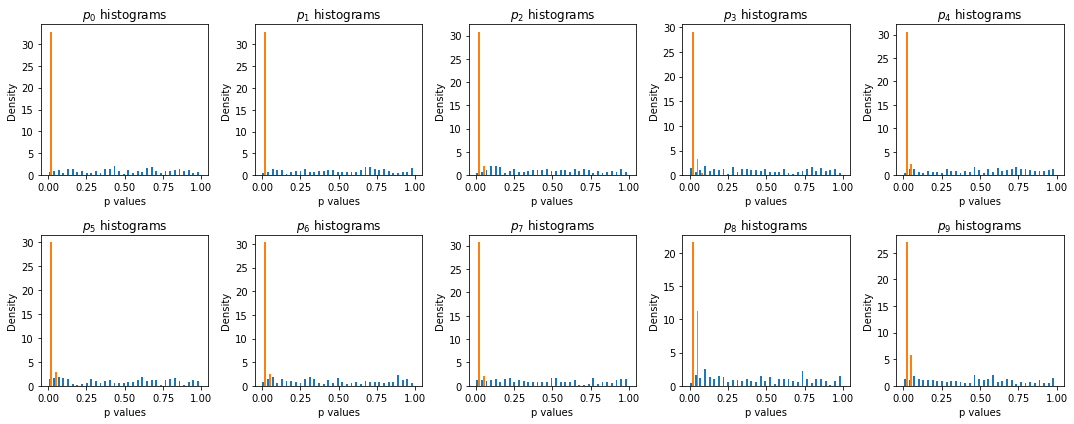

In [27]:
labels = list(range(10))

f,axs = plt.subplots(2,5,figsize=(15,6))
for i,ax in zip(labels,axs.ravel()):
    ax.hist((micp_pValues[i][y_test==i],micp_pValues[i][y_test!=i]),bins=np.linspace(0,1,34),density=True)
    ax.set_title("$p_%d$ histograms"%i)
    
    ax.set_ylabel("Density")
    ax.set_xlabel("p values")

f.tight_layout()

# Validity check

The charts below show the relationship between significance level and actual error rate for each of the labels.

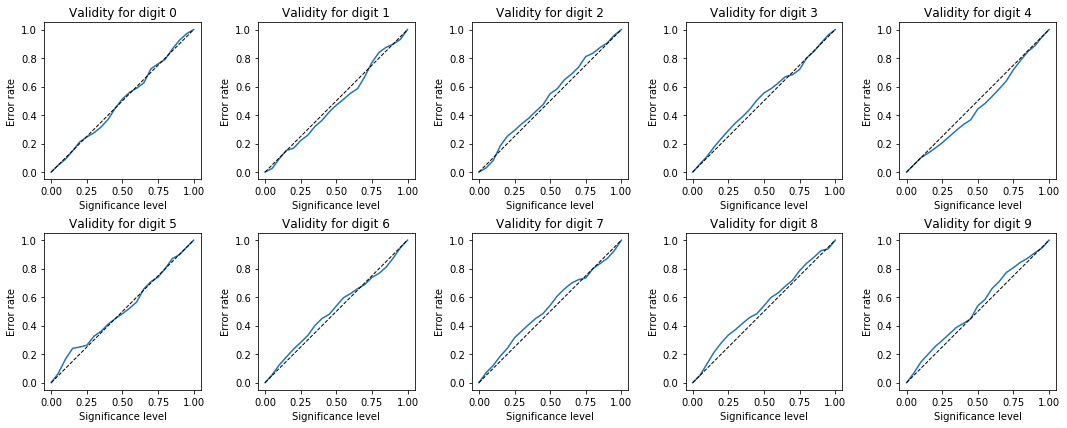

In [9]:
epsilons = np.linspace(0,1,21)
err_rates = np.zeros(shape=(y_test_hat.shape[1],epsilons.shape[0]))


for j,eps in enumerate(epsilons):
    prediction_sets = micp_pValues.T > eps     # row i is a "prediction set" for test object i
    for i in labels:
        err_rates[i,j] = 1-np.average(prediction_sets[y_test==i][:,i])

f,axs = plt.subplots(2,5,figsize=(15,6))
for i,ax in zip(labels,axs.ravel()):
    ax.plot(epsilons,err_rates[i])
    ax.plot((0,1),(0,1),"k--",lw=1)
    ax.set_title("Validity for digit %d"%i)
    ax.set_aspect(1)
    
    ax.set_xlabel("Significance level")
    ax.set_ylabel("Error rate")

f.tight_layout()

The plots provide a visual confirmation of validity, within statistical fluctuation.

# Prediction sets

This shows the prediction set for a chosen significance level test object.

The labels in the prediction set are shown in a column at the left of the image of the test object.

Moving the epsilon slider one can see the labels being turned on or off as lower or higher values of significance level are selected.

In [10]:
def show_pred_sets(eps,test_object_index,micp_pValues,X_test):
    prediction_set = micp_pValues.T[test_object_index] > eps
    
    f,ax = plt.subplots(figsize=(6,6))
    ax.imshow(X_test.reshape(-1,28,28)[test_object_index],cmap="Greys")
    ax.set_xticks([])
    ax.set_yticks([])
    display_labels = []
    for i,t in enumerate(prediction_set):
        if t:
            display_labels.append("%d"%i)
        else:
            display_labels.append("")
    display_labels = "\n".join(display_labels)
    ax.annotate(display_labels,
                xy=(0.05,0.95),xytext=(0.05,0.95),ha="left",va="top",xycoords="axes fraction",fontsize=16)
    
    return None

In [11]:
interact(show_pred_sets,
         eps=FloatSlider(value=0.01,min=0.0,max=0.2,step=0.005,
                         readout_format=".3f",
                         layout=Layout(width="80%")),
         test_object_index=IntSlider(value=0.01,min=0,max=X_test.shape[0],step=1,
                         readout_format="d",
                         layout=Layout(width="80%")),
         micp_pValues=fixed(micp_pValues),
         X_test=fixed(X_test));

interactive(children=(FloatSlider(value=0.01, description='eps', layout=Layout(width='80%'), max=0.2, readout_…

# How the size of the prediction sets vary with significance level

The interactive chart below shows the distribution of the size of the prediction sets. The slider lets you choose the significance level.

In [12]:
def show_pred_sizes(eps,micp_pValues,y_test):
    prediction_sets = micp_pValues > eps
    
    f,ax = plt.subplots(figsize=(12,6))
    ax.hist(np.sum(prediction_sets,axis=0),bins=np.linspace(-0.5,10.5,11))
    ax.set_ylim(0,prediction_sets.shape[1])
    err_rate = 1-np.average([p[i] for p,i in zip(prediction_sets.T,y_test)])
    efficiency = np.average(np.sum(prediction_sets,axis=0))
    ax.annotate("Error rate: {:.3f}\nAvg prediction size: {:.3f}".format(err_rate,efficiency),
                xy=(0.05,0.95),xytext=(0.05,0.95),ha="left",va="top",xycoords="axes fraction")
    ax.set_ylabel("Number of test objects")
    ax.set_xlabel("Size of prediction set")
    ax.set_xticks(list(range(11)))
    
    return None

In [13]:
interact(show_pred_sizes,eps=FloatSlider(value=0.01,min=0.0,max=0.2,step=0.005,
                                         readout_format=".3f",
                                         layout=Layout(width="50%")),
        micp_pValues=fixed(micp_pValues),
        y_test=fixed(y_test));

interactive(children=(FloatSlider(value=0.01, description='eps', layout=Layout(width='50%'), max=0.2, readout_…

In [18]:
import sklearn
sklearn.__version__

'0.21.2'